In [1]:
! pip3 -q install optax equinox

     |████████████████████████████████| 145 kB 29.6 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 85 kB 5.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.5 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
spacy 3.4.2 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
confection 0.0.3 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.


In [2]:
import jax.numpy as jnp
from jax import random, jit, config
import optax
import matplotlib.pyplot as plt
from functools import partial
config.update("jax_enable_x64", True)

%config InlineBackend.figure_format='retina'

In [3]:
! git init .
! git remote add origin https://github.com/VLSF/SDC
! git pull origin main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 47 (delta 17), reused 41 (delta 14), pack-reused 0
Unpacking objects: 100% (47/47), done.
From https://github.com/VLSF/SDC
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [4]:
from integrators import RK4, Explicit_Euler, Implicit_Euler

from sdc_integrators import RK4 as RK4_c
from sdc_integrators import Explicit_Euler as Explicit_Euler_c
from sdc_integrators import Implicit_Euler as Implicit_Euler_c
from sdc_integrators import Implicit_Euler as Implicit_Euler_cJ
from misc import utils, Chebyshev

# Residual

### $\exp$

In [5]:
exact = lambda x: jnp.exp(x)
F = lambda u, t: jnp.stack([u[0], ], -1)

N_points = 100
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = RK4.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
print("error ", error)
print("residual ", res)

error  7.56271045787571e-10
residual  4.669598041573408e-10


### logistic equation

In [6]:
exact = lambda x: 1 / (1 + jnp.exp(-x))
F = lambda u, t: jnp.stack([u[0] * (1 - u[0]), ], -1)

t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(100) + 1)/2 + t0
exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = RK4.integrator(u0, F, 100, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
print("error ", error)
print("residual ", res)

error  6.047384815133228e-12
residual  6.883826841885821e-12


### $\cos(\omega x)$

In [7]:
exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1)
G = utils.transform_to_interval(F, t0, t1)

t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(100) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = RK4.integrator(u0, F, 100, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
print("error ", error)
print("residual ", res)

error  1.7275147104277615e-05
residual  8.95311744811278e-06


# RK4

## $\sin(\omega t)$

In [8]:
exact = lambda x: -jnp.cos(x*jnp.pi)/jnp.pi
F = jit(lambda u, t: jnp.expand_dims(jnp.sin(t*jnp.pi), -1))

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = RK4.integrator(u0, F, N_points, t0, t1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(20):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

In [9]:
%timeit RK4_c.deferred_correction(values*3 + 0.1, F, t0, t1)

16.2 µs ± 185 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


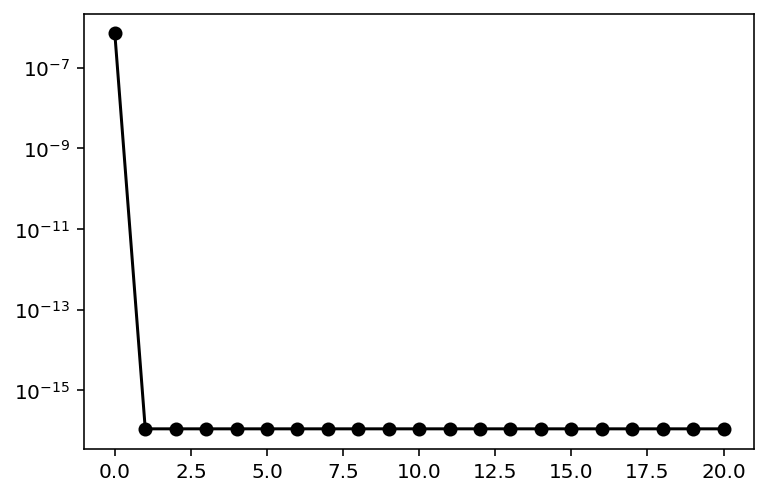

In [10]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## $\exp$

In [11]:
exact = lambda x: jnp.exp(x)
F = jit(lambda u, t: jnp.stack([u[0], ], -1))

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = RK4.integrator(u0, F, N_points, t0, t1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(20):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

In [12]:
%timeit RK4_c.deferred_correction(values*3 + 0.1, F, t0, t1)

14.2 µs ± 146 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


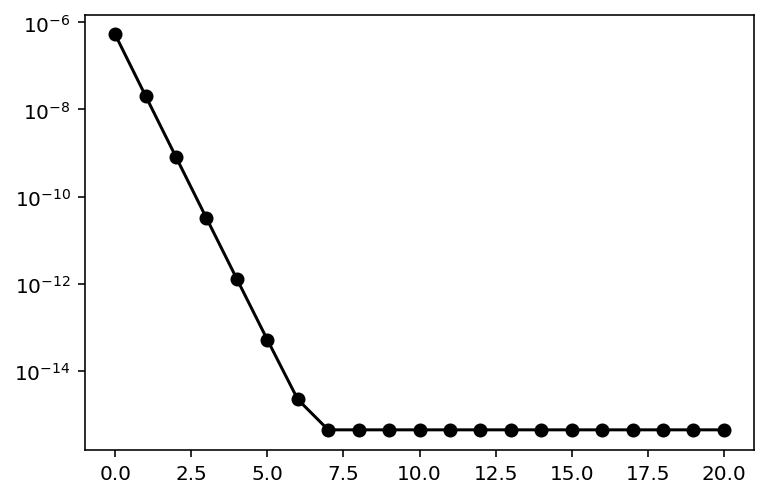

In [13]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## logistic equation

In [14]:
exact = lambda x: 1 / (1 + jnp.exp(-x))
F = jit(lambda u, t: jnp.stack([u[0] * (1 - u[0]), ], -1))

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = RK4.integrator(u0, F, N_points, t0, t1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(10):
  values =  RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

In [15]:
%timeit RK4_c.deferred_correction(values*3 + 0.1, F, t0, t1)

14.3 µs ± 288 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


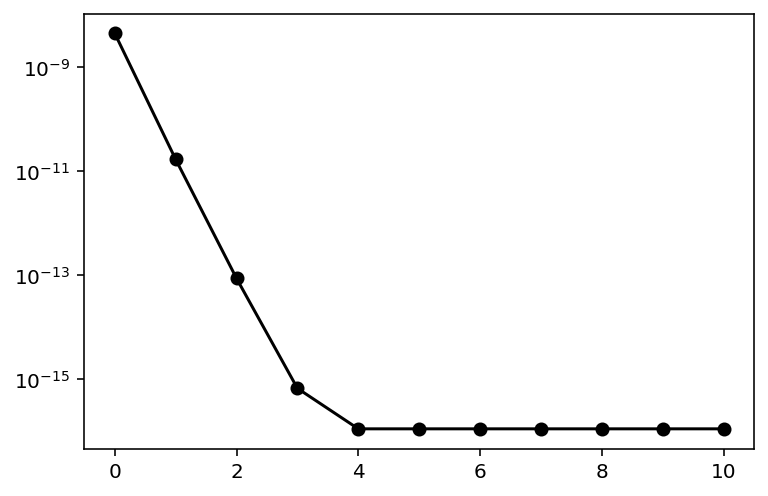

In [16]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## $\cos(\omega x)$

In [17]:
exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = jit(lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1))

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = RK4.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

In [18]:
%timeit  RK4_c.deferred_correction(values*3 + 0.1, F, t0, t1)

15.2 µs ± 196 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


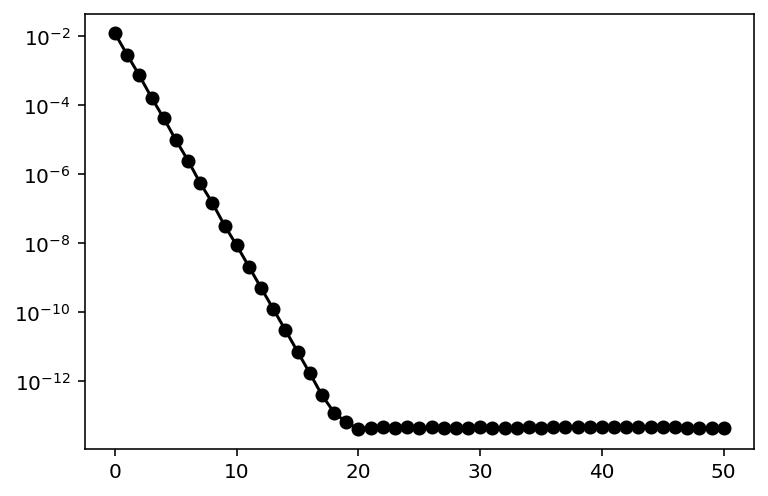

In [19]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

In [20]:
exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = jit(lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1))

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = RK4.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

In [21]:
%timeit RK4_c.deferred_correction(values*3 + 0.1, F, t0, t1)

21.8 µs ± 604 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


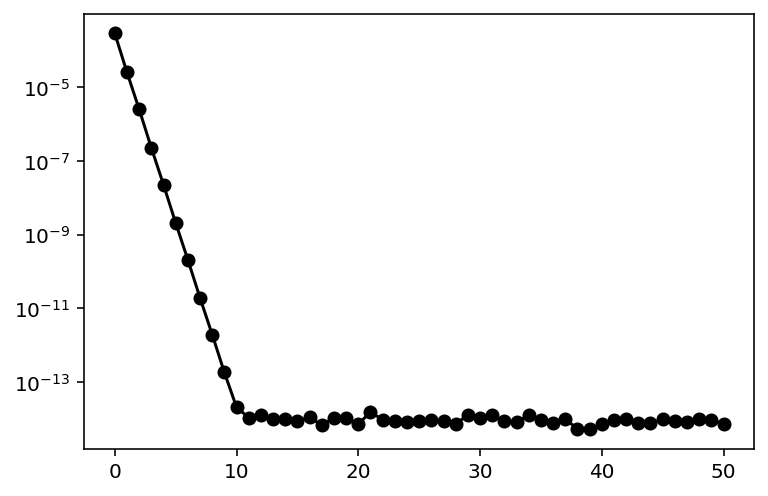

In [22]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## Prothero–Robinson $\delta = 0.1$

In [23]:
delta = 0.1
sigma = 1

exact = lambda x: jnp.expand_dims(sigma * jnp.exp(-delta*x) + jnp.sin(x), -1)
F = lambda u, t: jnp.expand_dims(jnp.cos(t) - delta*(u[0] - jnp.sin(t)), -1)

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = lambda u, t: jnp.expand_dims(jnp.cos(t) - delta*(u[0] - jnp.sin(t)), -1)

N_points = 20
t0, t1 = 0.0, 2*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = RK4.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

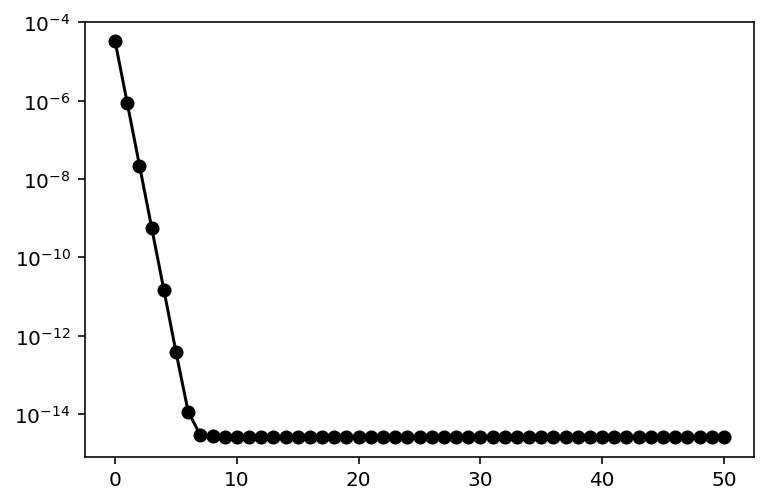

In [24]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## Prothero–Robinson $\delta = 7$

In [25]:
delta = 7
sigma = 1

exact = lambda x: jnp.expand_dims(sigma * jnp.exp(-delta*x) + jnp.sin(x), -1)
F = lambda u, t: jnp.expand_dims(jnp.cos(t) - delta*(u[0] - jnp.sin(t)), -1)

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = lambda u, t: jnp.expand_dims(jnp.cos(t) - delta*(u[0] - jnp.sin(t)), -1)

N_points = 20
t0, t1 = 0.0, 2*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = RK4.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

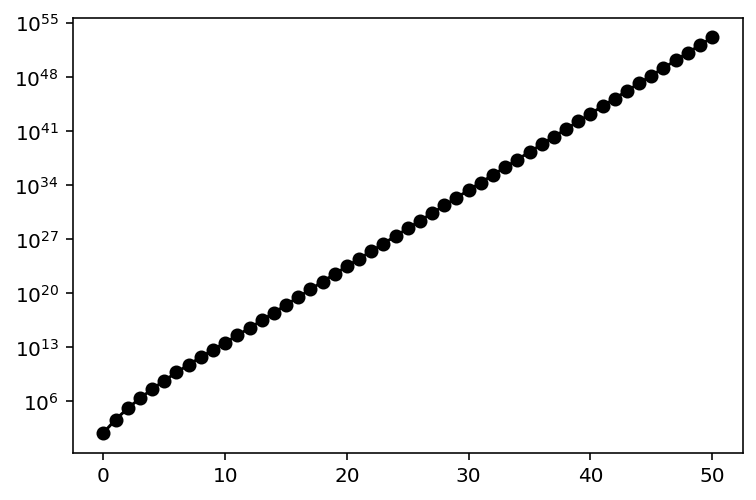

In [26]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## Van der Pol $\epsilon = 2$

In [27]:
epsilon = 2
F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 1.0])

values = RK4.integrator(u0, F, N_points, t0, t1)

res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

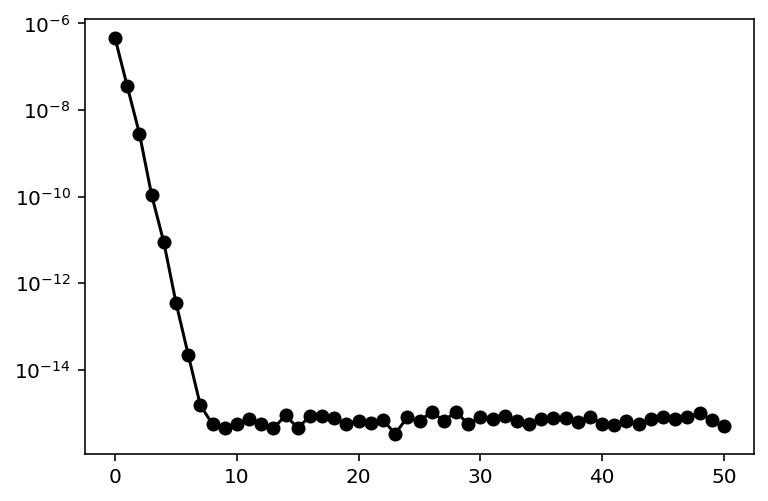

In [28]:
plt.yscale("log")
plt.plot(R, "o-", color="black");

## Van der Pol $\epsilon = 0.1$

In [29]:
epsilon = 0.1
F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 1.0])

values = RK4.integrator(u0, F, N_points, t0, t1)

res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

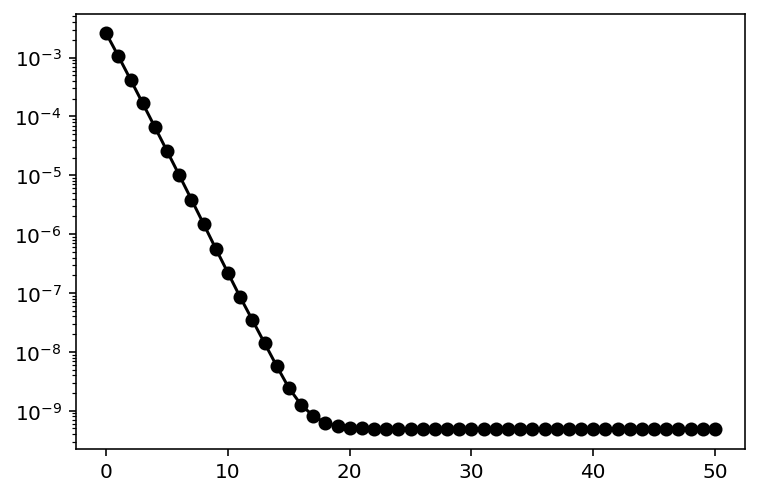

In [30]:
plt.yscale("log")
plt.plot(R, "o-", color="black");

## Van der Pol $\epsilon = 0.01$

In [31]:
epsilon = 0.01
F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

N_points = 40
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 1.0])

values = RK4.integrator(u0, F, N_points, t0, t1)

res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

# Explicit Euler

## $\sin(\omega t)$

In [32]:
exact = lambda x: -jnp.cos(x*jnp.pi)/jnp.pi
F = lambda u, t: jnp.expand_dims(jnp.sin(t*jnp.pi), -1)

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(20):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

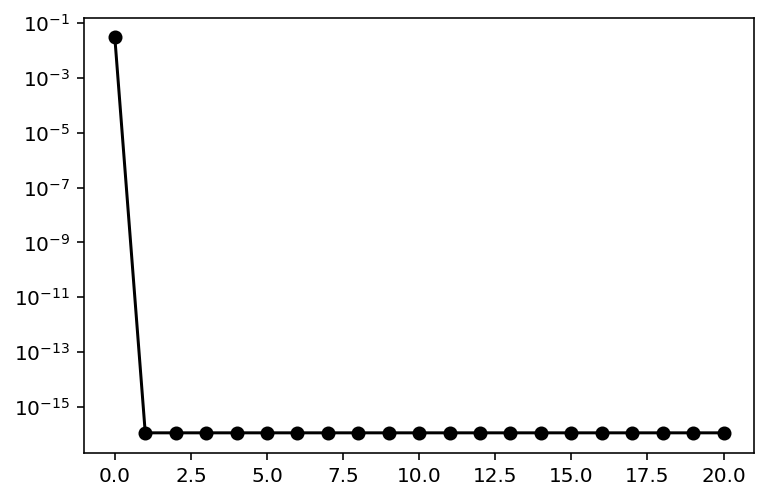

In [33]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## $\exp$

In [34]:
exact = lambda x: jnp.exp(x)
F = lambda u, t: jnp.stack([u[0], ], -1)

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(20):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

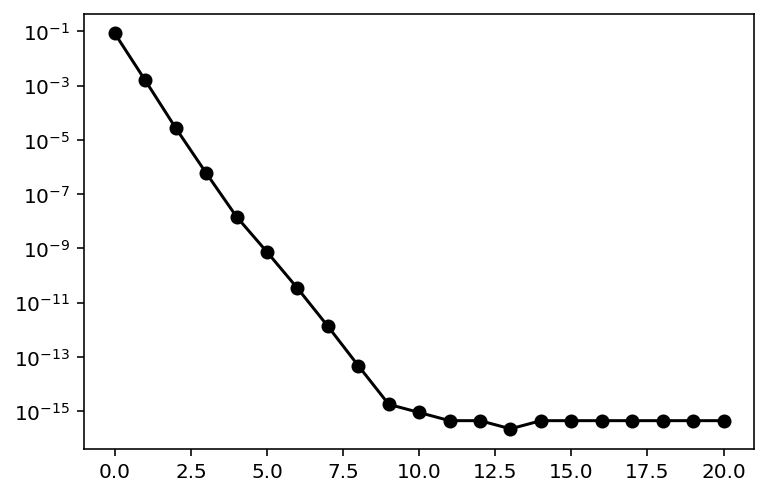

In [35]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## logistic equation

In [36]:
exact = lambda x: 1 / (1 + jnp.exp(-x))
F = jit(lambda u, t: jnp.stack([u[0] * (1 - u[0]), ], -1))

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(10):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

In [37]:
%timeit Explicit_Euler_c.deferred_correction(values*3 + 0.8, F, t0, t1)

13.7 µs ± 164 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


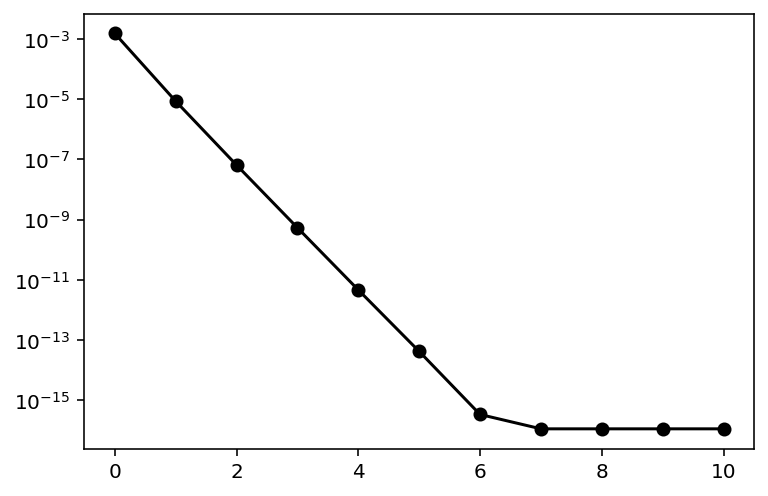

In [38]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## $\cos(\omega x)$

In [39]:
exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = jit(lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1))

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

In [40]:
%timeit Explicit_Euler_c.deferred_correction(values*3 + 0.8, F, t0, t1)

19.6 µs ± 8.29 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


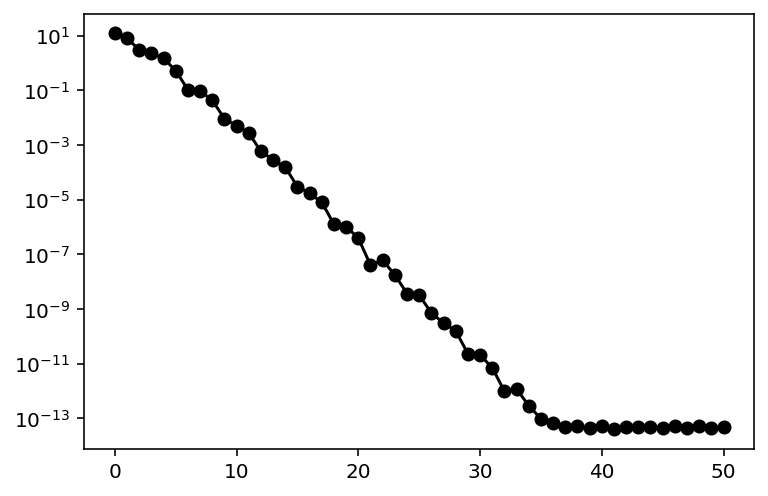

In [41]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

In [42]:
exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1)

exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1)

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

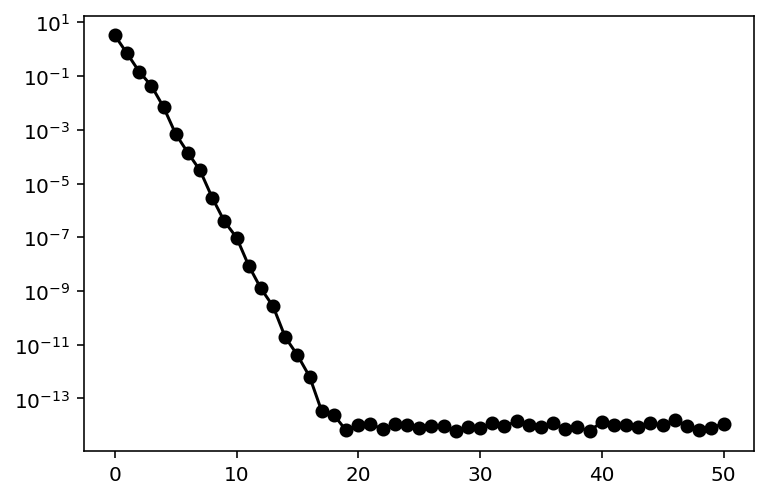

In [43]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

In [44]:
exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1)

exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1)

N_points = 100
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

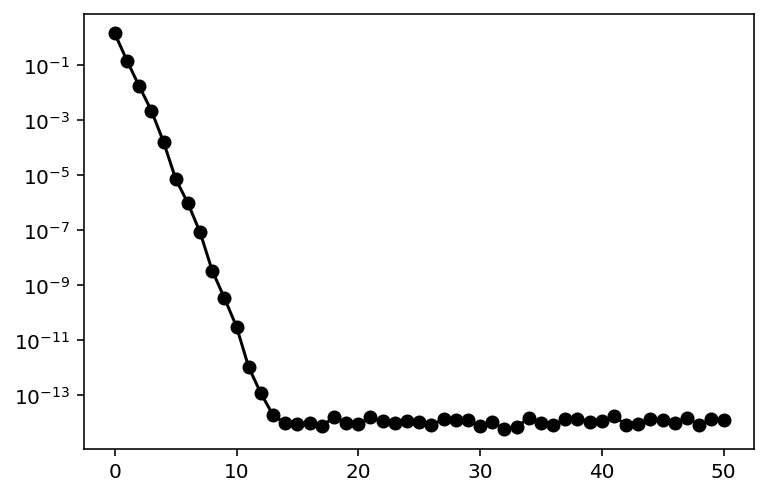

In [45]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

In [46]:
exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1)

exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1)

N_points = 150
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

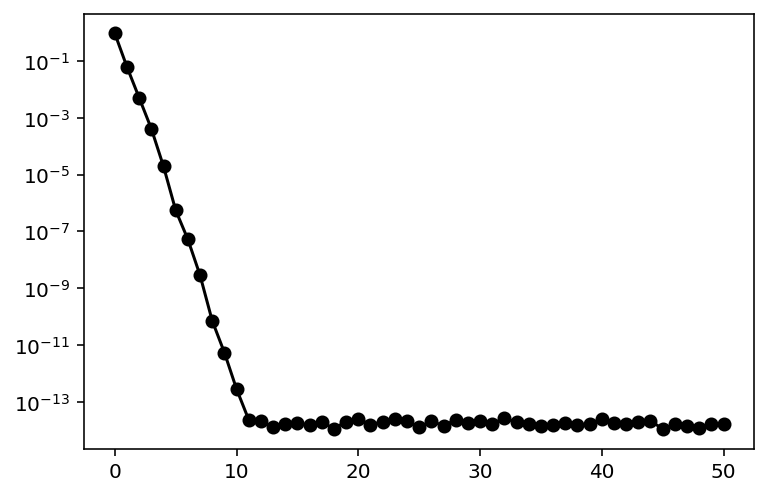

In [47]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## Prothero–Robinson $\delta = 0.1$

In [48]:
delta = 0.1
sigma = 1

exact = lambda x: jnp.expand_dims(sigma * jnp.exp(-delta*x) + jnp.sin(x), -1)
F = lambda u, t: jnp.expand_dims(jnp.cos(t) - delta*(u[0] - jnp.sin(t)), -1)

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = lambda u, t: jnp.expand_dims(jnp.cos(t) - delta*(u[0] - jnp.sin(t)), -1)

N_points = 20
t0, t1 = 0.0, 2*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

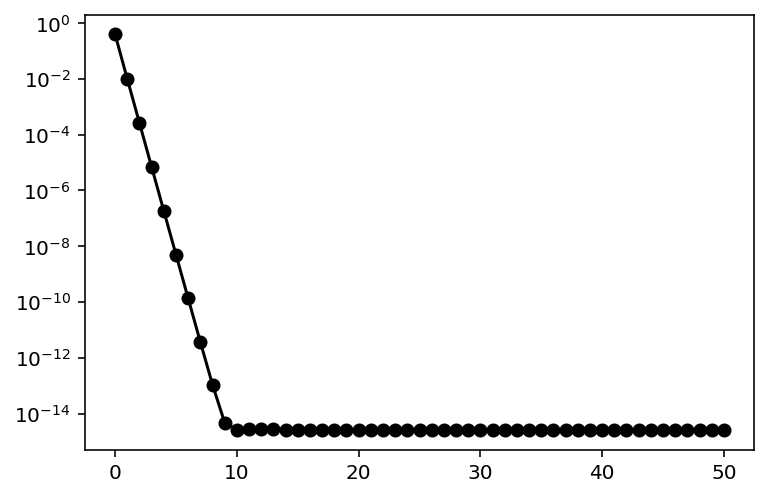

In [49]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## Prothero–Robinson $\delta = 7$

In [50]:
delta = 7
sigma = 1

exact = lambda x: jnp.expand_dims(sigma * jnp.exp(-delta*x) + jnp.sin(x), -1)
F = lambda u, t: jnp.expand_dims(jnp.cos(t) - delta*(u[0] - jnp.sin(t)), -1)

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = lambda u, t: jnp.expand_dims(jnp.cos(t) - delta*(u[0] - jnp.sin(t)), -1)

N_points = 20
t0, t1 = 0.0, 2*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(10):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

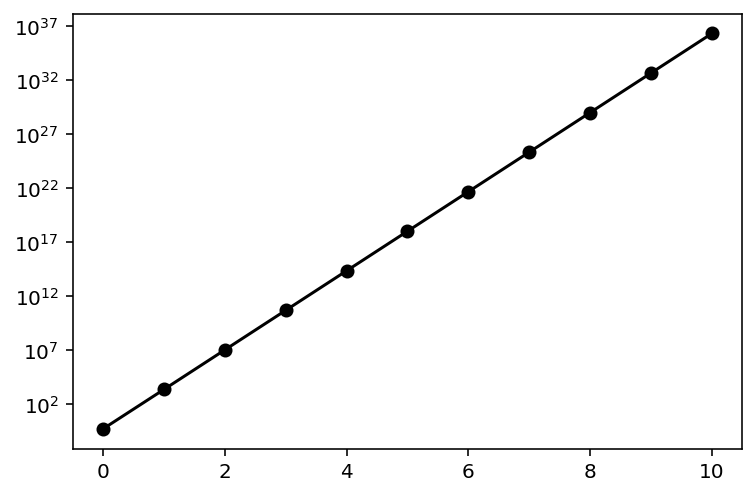

In [51]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## Van der Pol $\epsilon = 2$

In [52]:
epsilon = 2
F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 1.0])

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)

res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

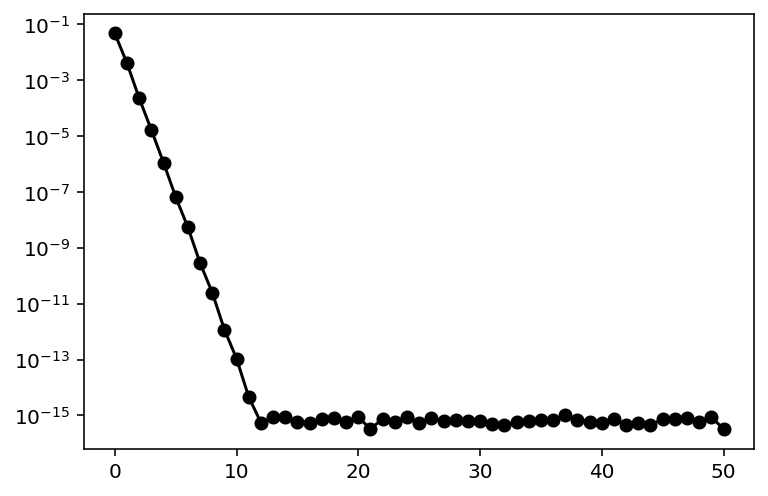

In [53]:
plt.yscale("log")
plt.plot(R, "o-", color="black");

## Van der Pol $\epsilon = 0.1$

In [54]:
epsilon = 0.1
F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 1.0])

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)

res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

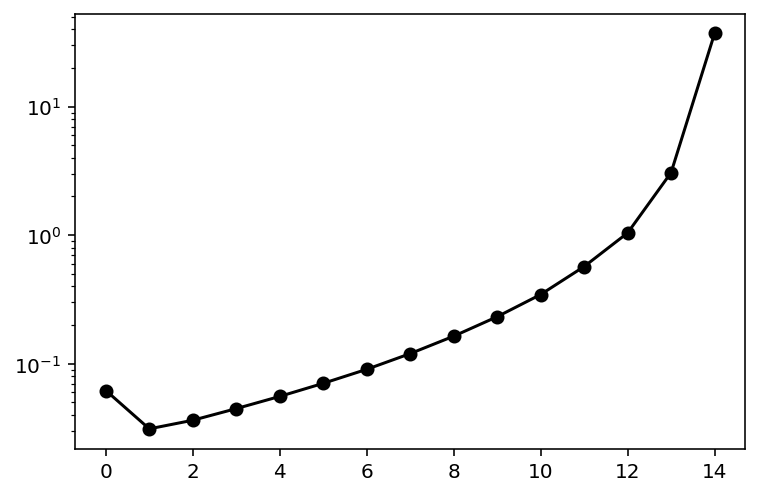

In [55]:
plt.yscale("log")
plt.plot(R, "o-", color="black");

# Implicit Euler

## $\sin(\omega t)$

### With autograd

In [56]:
exact = lambda x: -jnp.cos(x*jnp.pi)/jnp.pi
F = lambda u, t: jnp.expand_dims(jnp.sin(t*jnp.pi), -1)

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(20):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

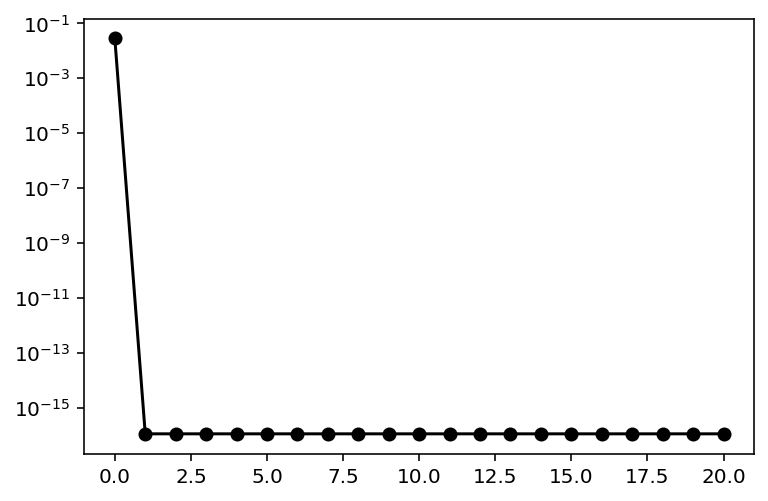

In [57]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

### Without autograd

In [58]:
N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.exp(x)
F = jit(lambda u, t: jnp.stack([u[0], ], -1))
inv_dF = jit(lambda u, u_F, t, h: u_F / (1 - h*(t1-t0)/2))

exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

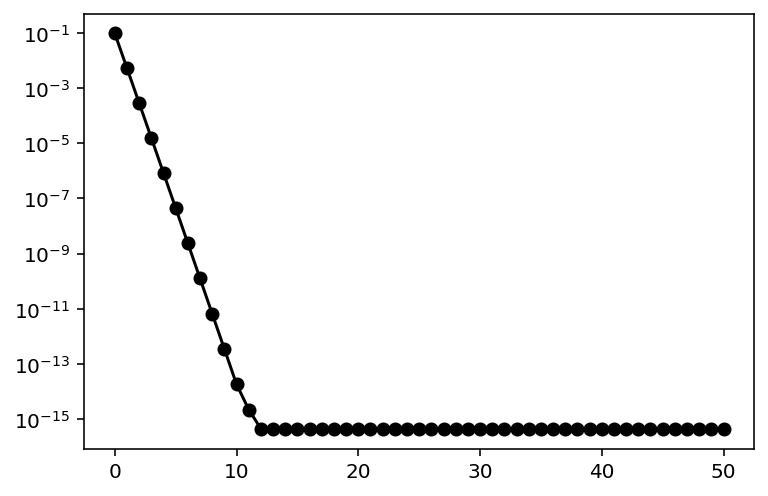

In [59]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## $\exp$

### With autograd

In [60]:
exact = lambda x: jnp.exp(x)
F = lambda u, t: jnp.stack([u[0], ], -1)

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(20):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

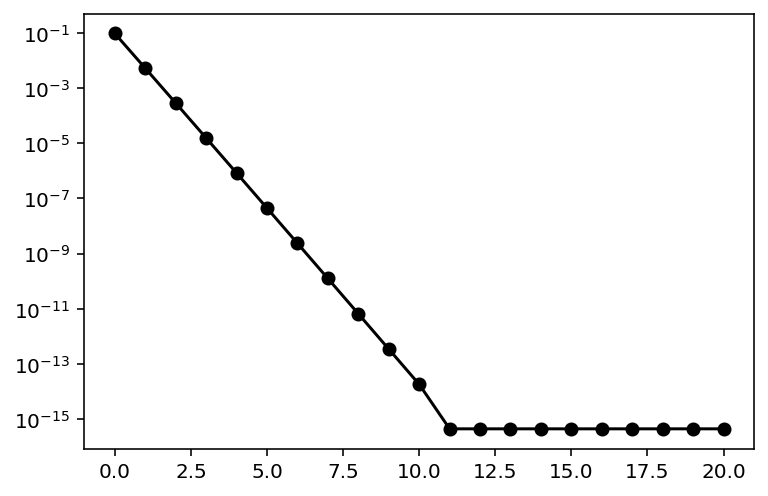

In [61]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

### Without autograd

In [62]:
N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.exp(x)
F = jit(lambda u, t: jnp.stack([u[0], ], -1))
inv_dF = jit(lambda u, u_F, t, h: u_F / (1 - h*(t1-t0)/2))

exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

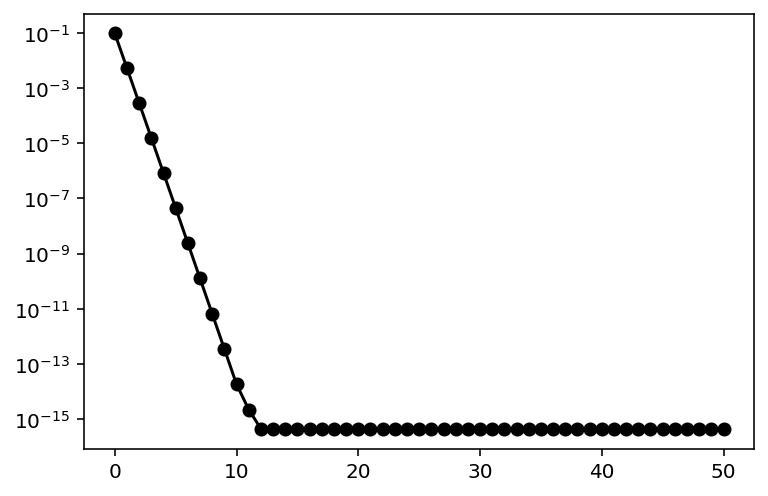

In [63]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## logistic equation

### With autograd

In [64]:
exact = lambda x: 1 / (1 + jnp.exp(-x))
F = jit(lambda u, t: jnp.stack([u[0] * (1 - u[0]), ], -1))

N_points = 100
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(10):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

In [65]:
%timeit Implicit_Euler_c.deferred_correction(values*2 + 0.3, F, t0, t1, 1)

48.1 µs ± 936 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


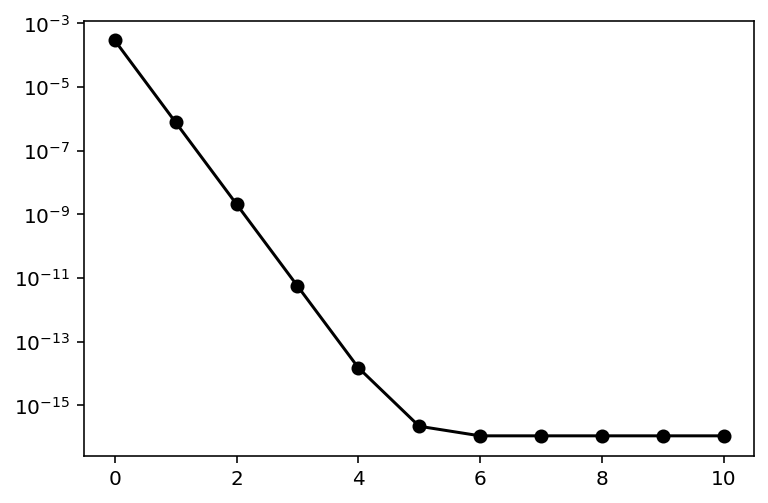

In [66]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

### Without autograd

In [67]:
N_points = 100
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: 1 / (1 + jnp.exp(-x))
F = jit(lambda u, t: jnp.stack([u[0] * (1 - u[0]), ], -1))
inv_dF = jit(lambda u, u_F, t, h: u_F / (1 - h*(1-2*u)*(t1-t0)/2))

exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(10):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

In [68]:
%timeit Implicit_Euler_c.deferred_correction_J(values*2 + 0.3, F, inv_dF, t0, t1, 1)

22.6 µs ± 190 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


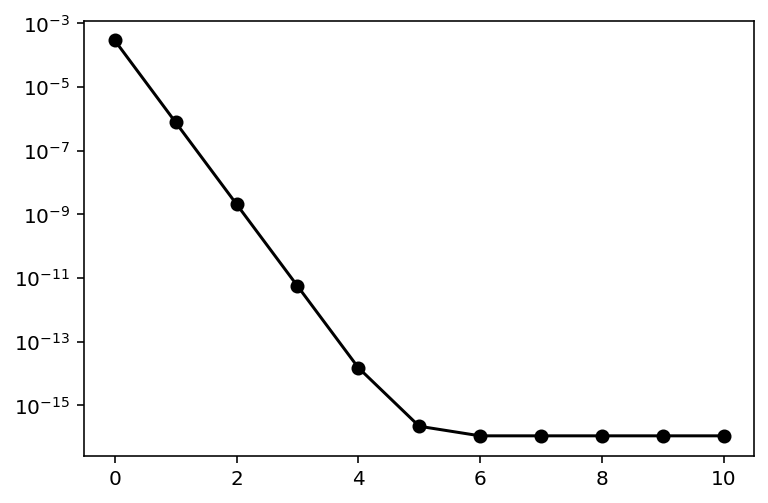

In [69]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## $\cos(\omega x)$

### With autograd

In [70]:
exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = jit(lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1))

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

In [71]:
%timeit Implicit_Euler_c.deferred_correction(values*3 + 0.3, F, t0, t1, 1)

39.1 µs ± 731 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


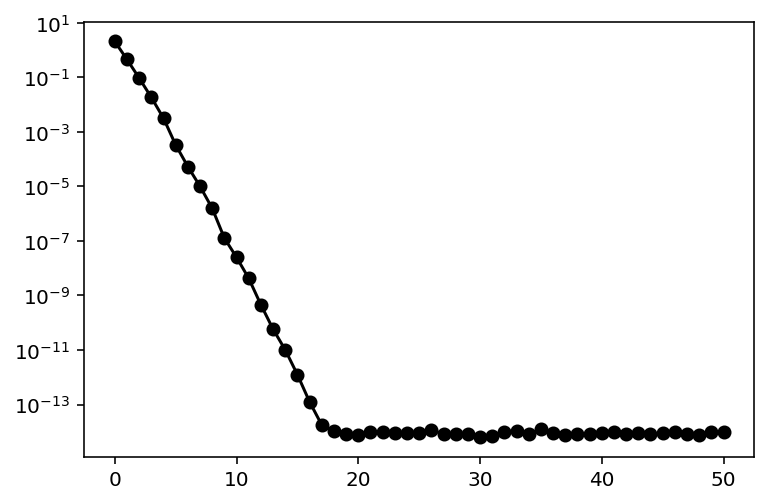

In [72]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

### Without autograd

In [73]:
N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = jit(lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1))
inv_dF = jit(lambda u, u_F, t, h: jnp.stack([u_F[0] + h*u_F[1]*(t1 - t0)/2, -h*(2*jnp.pi)**2*u_F[0]*(t1 - t0)/2 + u_F[1]], -1) / (1 + (2*h*(t1 - t0)/2*jnp.pi)**2))

exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

In [74]:
%timeit Implicit_Euler_c.deferred_correction_J(values*3 + 0.3, F, inv_dF, t0, t1, 1)

19.2 µs ± 249 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


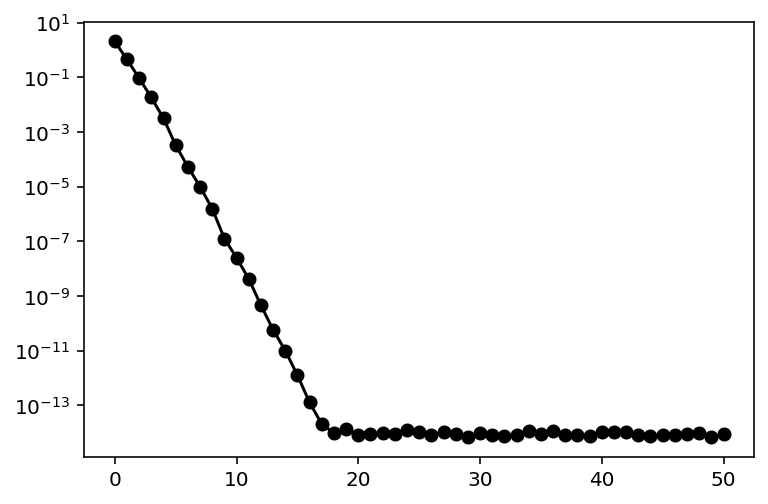

In [75]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## Prothero–Robinson $\delta = 0.1$

### With autograd

In [76]:
delta = 0.1
sigma = 1

exact = lambda x: jnp.expand_dims(sigma * jnp.exp(-delta*x) + jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)), ], -1))

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 20
t0, t1 = 0.0, 2*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

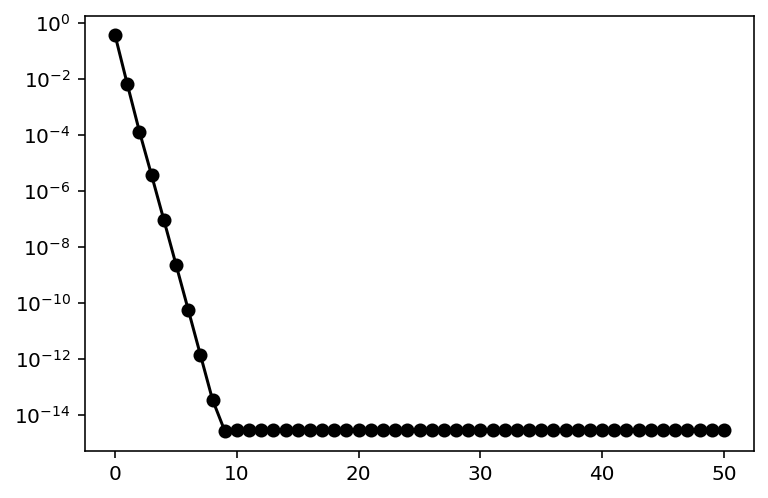

In [77]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

### Without autograd

In [78]:
delta = 0.1
sigma = 1
N_points = 20
t0, t1 = 0.0, 2*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))
inv_dF = lambda u, u_F, t, h: u_F / (1 + h*delta*(t1-t0)/2)

exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

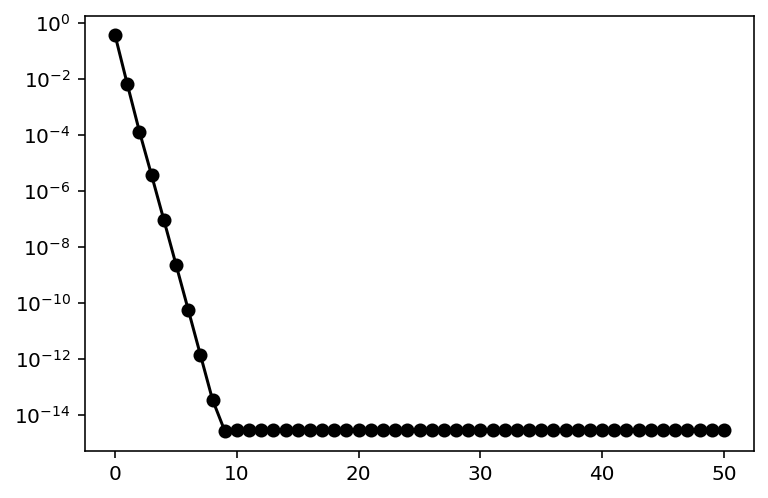

In [79]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## Prothero–Robinson $\delta = 7$

### With autograd

In [80]:
delta = 7
sigma = 1

exact = lambda x: jnp.expand_dims(sigma * jnp.exp(-delta*x) + jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)), ], -1))

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 20
t0, t1 = 0.0, 2*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(100):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

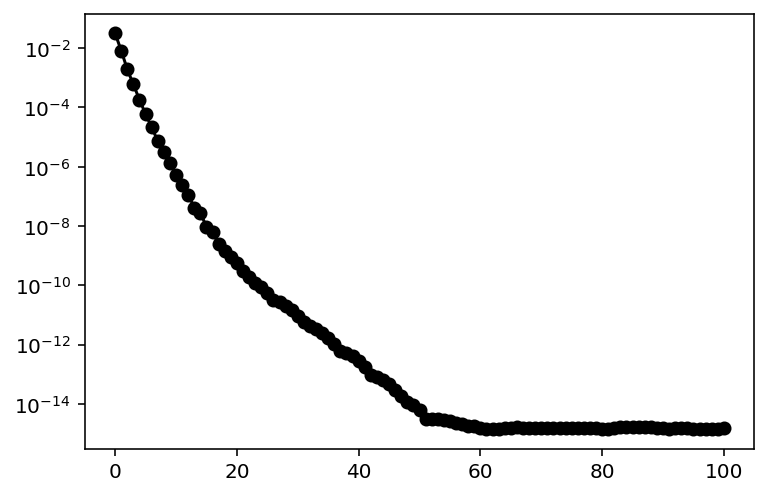

In [81]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

### Without autograd

In [82]:
delta = 7
sigma = 1
N_points = 20
t0, t1 = 0.0, 2*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))
inv_dF = lambda u, u_F, t, h: u_F / (1 + h*delta*(t1-t0)/2)

exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(100):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

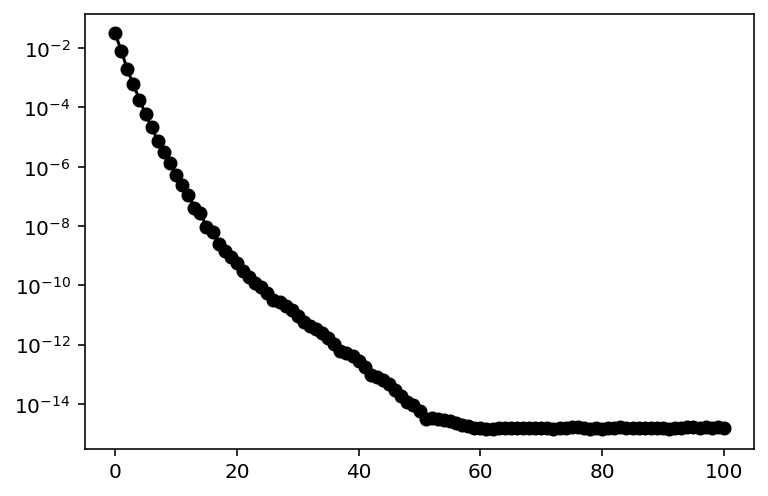

In [83]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## Prothero–Robinson $\delta = 20$

In [84]:
delta = 20
sigma = 1
N_points = 20
t0, t1 = 0.0, 2*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))
inv_dF = lambda u, u_F, t, h: u_F / (1 + h*delta*(t1-t0)/2)

exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(400):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

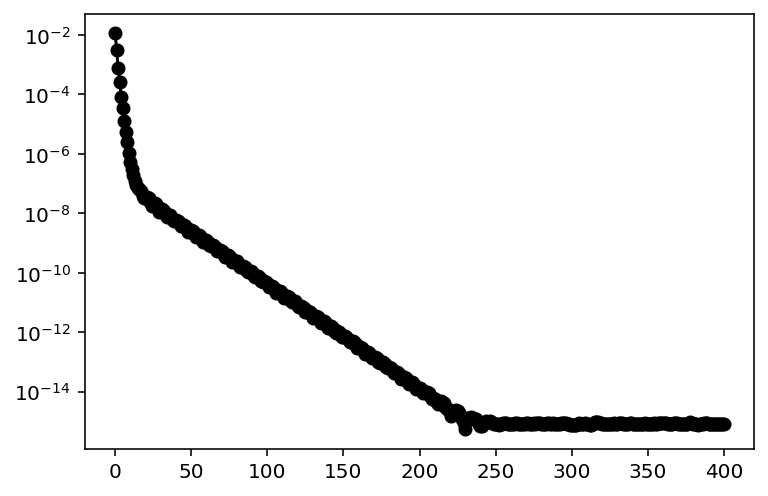

In [85]:
plt.yscale("log")
plt.plot(E, "o-", color="black");

## Van der Pol $\epsilon = 2$

In [86]:
epsilon = 2

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 1.0])

F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

@jit
def inv_dF(u, u_F, t, h):
  h_ = h*(t1-t0)/2
  det = (1 + u[0]**2*h_/epsilon) + h_**2 * (2*u[0]*u[1]/epsilon + 1)
  u0 = ((1 + u[0]**2*h_/epsilon) * u_F[0] + h_ * u_F[1]) / det
  u1 = (u_F[1] - h_*(2*u[0]*u[1]/epsilon + 1) * u_F[0]) / det
  return jnp.stack([u0, u1], -1)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

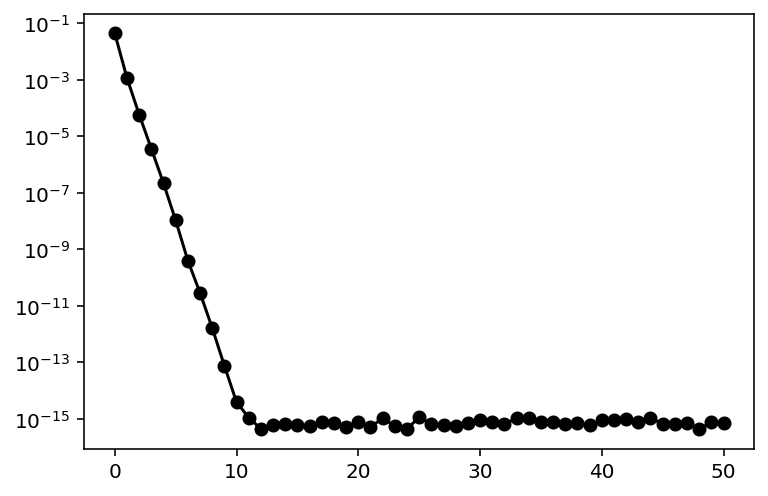

In [87]:
plt.yscale("log")
plt.plot(R, "o-", color="black");

## Van der Pol $\epsilon = 0.1$

In [88]:
epsilon = 0.1

N_points = 20
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 1.0])

F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

@jit
def inv_dF(u, u_F, t, h):
  h_ = h*(t1-t0)/2
  det = (1 + u[0]**2*h_/epsilon) + h_**2 * (2*u[0]*u[1]/epsilon + 1)
  u0 = ((1 + u[0]**2*h_/epsilon) * u_F[0] + h_ * u_F[1]) / det
  u1 = (u_F[1] - h_*(2*u[0]*u[1]/epsilon + 1) * u_F[0]) / det
  return jnp.stack([u0, u1], -1)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

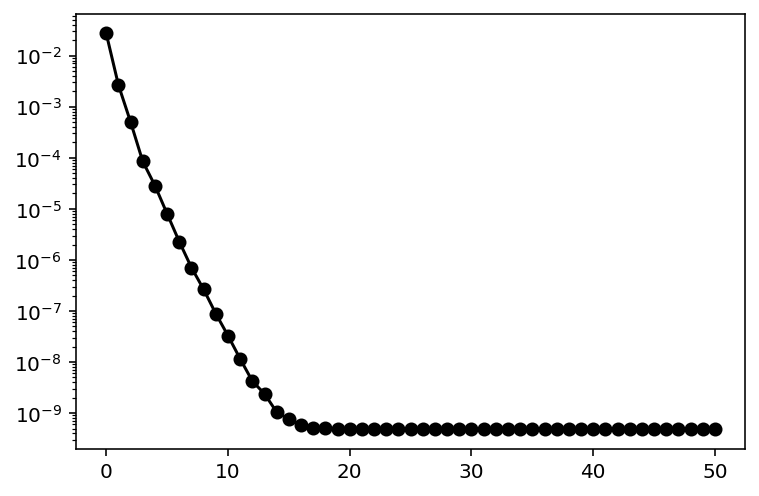

In [89]:
plt.yscale("log")
plt.plot(R, "o-", color="black");

## Van der Pol $\epsilon = 0.01$

In [90]:
epsilon = 0.01

N_points = 40
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 1.0])

F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

@jit
def inv_dF(u, u_F, t, h):
  h_ = h*(t1-t0)/2
  det = (1 + u[0]**2*h_/epsilon) + h_**2 * (2*u[0]*u[1]/epsilon + 1)
  u0 = ((1 + u[0]**2*h_/epsilon) * u_F[0] + h_ * u_F[1]) / det
  u1 = (u_F[1] - h_*(2*u[0]*u[1]/epsilon + 1) * u_F[0]) / det
  return jnp.stack([u0, u1], -1)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res,]

for i in range(100):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

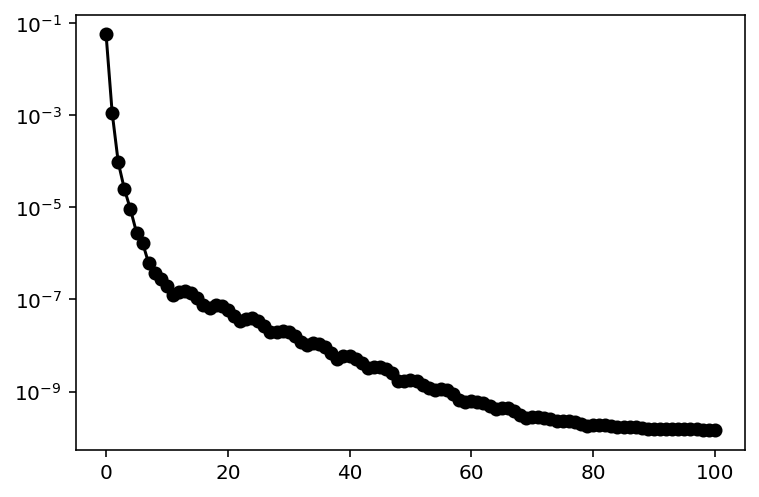

In [91]:
plt.yscale("log")
plt.plot(R, "o-", color="black");